<a href="https://colab.research.google.com/github/dwiratomo12/model/blob/main/InceptionV3_Input_Shape_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InceptionV3 Input Shape 256

In [ ]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'
!kaggle datasets download -d jarvis705/tomato-leaf-disease

Done
 97% 313M/322M [00:03<00:00, 78.8MB/s]
100% 322M/322M [00:04<00:00, 83.2MB/s]


In [ ]:
from zipfile import ZipFile

filename = "tomato-leaf-disease.zip"

with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('Done!')

Done!


In [ ]:
import os
import shutil


new_classname=['Tomato Bacterial spot','Tomato Early blight','Tomato Late blight', 
         'Tomato Leaf Mold','Tomato Septoria leaf spot','Tomato Spider mites Two-spotted mite',
         'Tomato Target Spot','Tomato Yellow Leaf Curl Virus','Tomato Mosaic virus','Tomato Healthy']

for name in new_classname:
    os.makedirs('/content/Tomato Leaf Diseases/Dataset/'+name+'/')

classes=['Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight', 
         'Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite',
         'Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']

def merge_data(nameClass, new_classname): 
  destination = '/content/Tomato Leaf Diseases/Dataset/'+new_classname+'/'
  validationset_source = '/content/Tomato Leaf Diseases/Validation Set/' +nameClass+ '/'
  trainingset_source = '/content/Tomato Leaf Diseases/Training Set/' +nameClass+ '/'

  validationset_listdir = os.listdir(validationset_source)
  validationset_filenames = [validationset_source+name for name in validationset_listdir]
  trainingset_listdir = os.listdir(trainingset_source)
  trainingset_filenames = [trainingset_source+name for name in trainingset_listdir]

  for name in trainingset_filenames:
      basename = os.path.basename(name)
      base, extension = os.path.splitext(basename)
      if not os.path.exists(os.path.join(destination, '{}_{}'.format(new_classname, basename))):
        shutil.copy(name, os.path.join(destination, '{}_{}'.format(new_classname, basename)))
      else:
        base, extension = os.path.splitext(basename)
        number = 1
        while os.path.exists(os.path.join(destination, '{}_{}{}{}'.format(new_classname, base, number, extension))):
          number += 1
        shutil.copy(name, os.path.join(destination, '{}_{}{}{}'.format(new_classname, base, number, extension)))

  for name in validationset_filenames:
      basename = os.path.basename(name)
      base, extension = os.path.splitext(basename)
      if not os.path.exists(os.path.join(destination, '{}_{}'.format(new_classname, basename))):
        shutil.copy(name, os.path.join(destination, '{}_{}'.format(new_classname, basename)))
      else:
        base, extension = os.path.splitext(basename)
        number = 1
        while os.path.exists(os.path.join(destination, '{}_{}{}{}'.format(new_classname, base, number, extension))):
          number += 1
        shutil.copy(name, os.path.join(destination, '{}_{}{}{}'.format(new_classname, base, number, extension)))


for i in range(len(classes)):
  merge_data(classes[i], new_classname[i])

In [ ]:
data_dir = '/content/Tomato Leaf Diseases/Dataset'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.3)

train_generator = datagen.flow_from_directory(
    data_dir, 
    subset="training", 
    shuffle=True, 
    target_size=(256,256),
    seed=42,
    color_mode="rgb", 
    class_mode="categorical")

validation_generator = datagen.flow_from_directory(
    data_dir, 
    shuffle=False, 
    subset="validation",
    target_size=(256,256),
    seed=42,
    color_mode="rgb",
    class_mode="categorical")


Found 11900 images belonging to 10 classes.
Found 5100 images belonging to 10 classes.


# Keras Applications

In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(256, 256, 3))

base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(Flatten())
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(train_generator.num_classes, activation='softmax'))

model = add_model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               37749248  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 59,557,162
Trainable params: 37,754,378
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
from tensorflow import keras

#LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
file_path="model_best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callbacks_list = [checkpoint]
#callbacks_list = [checkpoint, early] #early

history = model.fit(
          train_generator,
          steps_per_epoch=train_generator.samples//train_generator.batch_size,
          epochs=30,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples//validation_generator.batch_size,
          callbacks=callbacks_list)

Epoch 1/30
371/371 [==============================] - 89s 154ms/step - loss: 8.4062 - accuracy: 0.4796 - val_loss: 0.7684 - val_accuracy: 0.7349

Epoch 00001: val_loss improved from inf to 0.76845, saving model to model_best.hdf5
Epoch 2/30
371/371 [==============================] - 53s 139ms/step - loss: 0.8869 - accuracy: 0.6958 - val_loss: 0.6026 - val_accuracy: 0.7919

Epoch 00002: val_loss improved from 0.76845 to 0.60260, saving model to model_best.hdf5
Epoch 3/30
371/371 [==============================] - 52s 141ms/step - loss: 0.6414 - accuracy: 0.7746 - val_loss: 0.5894 - val_accuracy: 0.8082

Epoch 00003: val_loss improved from 0.60260 to 0.58936, saving model to model_best.hdf5
Epoch 4/30
371/371 [==============================] - 52s 141ms/step - loss: 0.5981 - accuracy: 0.7830 - val_loss: 0.5128 - val_accuracy: 0.8208

Epoch 00004: val_loss improved from 0.58936 to 0.51279, saving model to model_best.hdf5
Epoch 5/30
371/371 [==============================] - 52s 141ms/step

In [ ]:
from keras.models import load_model
import numpy as np

filepath = "/content/model_best.hdf5"

# Load the model
model = load_model(filepath, compile = True)


In [ ]:
preds = model.predict_generator(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)

# Visualisasi Data

In [ ]:
import matplotlib.pyplot as plt

def plot_train_history(history1):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

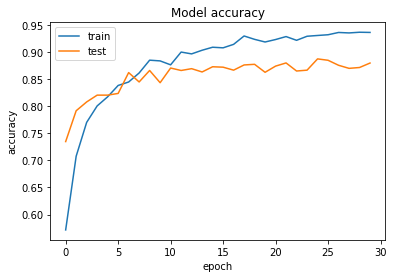

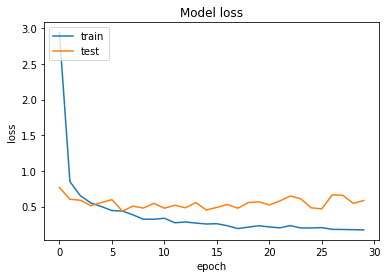

In [ ]:
plot_train_history(history)

Saving image (1023).JPG to image (1023).JPG


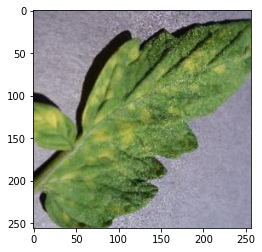

[8.56988223e-08 2.78576370e-03 8.10670864e-10 5.16621396e-03
 9.60843444e-01 1.32871255e-05 3.10025513e-02 4.33433271e-08
 1.88602891e-04 1.43930752e-08]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.28%
Tomato Healthy: 0.00%
Tomato Late blight: 0.52%
Tomato Leaf Mold: 96.08%
Tomato Mosaic virus: 0.00%
Tomato Septoria leaf spot: 3.10%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 0.02%
Tomato Yellow Leaf Curl Virus: 0.00%


In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  print(proba)
  for i in range(len(labels)):
    print("{}: {:.2f}%".format(labels[i], proba[i]* 100))

# SGD

In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(256, 256, 3))

base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(Flatten())
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(train_generator.num_classes, activation='softmax'))

model_sgd = add_model

model_sgd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 40,679,978
Trainable params: 18,877,194
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
from tensorflow import keras

model_sgd.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4,
                                                 momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
file_path="model_sgd_best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callbacks_list = [checkpoint]
#callbacks_list = [checkpoint, early] #early

history = model_sgd.fit(
          train_generator,
          steps_per_epoch=train_generator.samples//train_generator.batch_size,
          epochs=30,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples//validation_generator.batch_size,
          callbacks=callbacks_list)

Epoch 1/30
371/371 [==============================] - 72s 154ms/step - loss: 1.7646 - accuracy: 0.4152 - val_loss: 0.7510 - val_accuracy: 0.7654

Epoch 00001: val_loss improved from inf to 0.75096, saving model to model_sgd_best.hdf5
Epoch 2/30
371/371 [==============================] - 51s 137ms/step - loss: 0.8325 - accuracy: 0.7220 - val_loss: 0.5752 - val_accuracy: 0.8118

Epoch 00002: val_loss improved from 0.75096 to 0.57521, saving model to model_sgd_best.hdf5
Epoch 3/30
371/371 [==============================] - 51s 137ms/step - loss: 0.6427 - accuracy: 0.7890 - val_loss: 0.4939 - val_accuracy: 0.8435

Epoch 00003: val_loss improved from 0.57521 to 0.49394, saving model to model_sgd_best.hdf5
Epoch 4/30
371/371 [==============================] - 51s 136ms/step - loss: 0.4983 - accuracy: 0.8374 - val_loss: 0.4492 - val_accuracy: 0.8498

Epoch 00004: val_loss improved from 0.49394 to 0.44924, saving model to model_sgd_best.hdf5
Epoch 5/30
371/371 [==============================] 

# Confusion Matrix

In [ ]:
from keras.models import load_model
import numpy as np

filepath = "/content/model_sgd_best.hdf5"

# Load the model
model = load_model(filepath, compile = True)

In [ ]:
preds = model.predict_generator(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)

Saving image (1018).JPG to image (1018).JPG


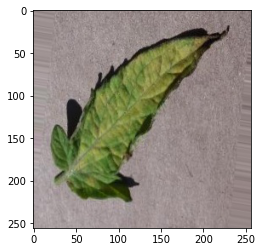

[6.7589831e-08 9.9682602e-06 2.8907263e-07 9.6857264e-05 9.9977428e-01
 8.8643690e-05 2.1848020e-05 1.7573367e-07 2.7333999e-07 7.5960547e-06]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Healthy: 0.00%
Tomato Late blight: 0.01%
Tomato Leaf Mold: 99.98%
Tomato Mosaic virus: 0.01%
Tomato Septoria leaf spot: 0.00%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 0.00%
Tomato Yellow Leaf Curl Virus: 0.00%


In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  print(proba)
  for i in range(len(labels)):
    print("{}: {:.2f}%".format(labels[i], proba[i]* 100))

# TensorFlow Hub Feature Vector

In [ ]:
import tensorflow_hub as hub

In [ ]:
handle_base = "inception_v3"
FV_SIZE = 2048
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   trainable=False,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 22,857,002
Trainable params: 1,054,218
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
#LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

#checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
371/371 [==============================] - 53s 143ms/step - loss: 0.4479 - accuracy: 0.8460 - val_loss: 0.3945 - val_accuracy: 0.8607
Epoch 2/20
371/371 [==============================] - 54s 145ms/step - loss: 0.3898 - accuracy: 0.8684 - val_loss: 0.4057 - val_accuracy: 0.8542
Epoch 3/20
371/371 [==============================] - 53s 144ms/step - loss: 0.3477 - accuracy: 0.8788 - val_loss: 0.3641 - val_accuracy: 0.8681
Epoch 4/20
371/371 [==============================] - 53s 144ms/step - loss: 0.3418 - accuracy: 0.8765 - val_loss: 0.4873 - val_accuracy: 0.8390
Epoch 5/20
371/371 [==============================] - 53s 144ms/step - loss: 0.3004 - accuracy: 0.8927 - val_loss: 0.3836 - val_accuracy: 0.8652
Epoch 6/20
371/371 [==============================] - 53s 142ms/step - loss: 0.2772 - accuracy: 0.9035 - val_loss: 0.3651 - val_accuracy: 0.8719
Epoch 7/20
371/371 [==============================] - 52s 140ms/step - loss: 0.2728 - accuracy: 0.9036 - val_loss: 0.3755 - val_ac

# Visualisasi

In [ ]:
import matplotlib.pyplot as plt

def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

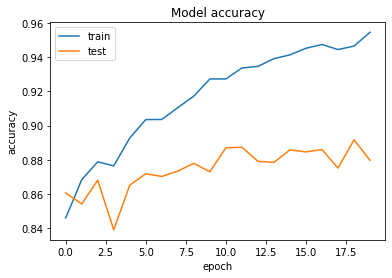

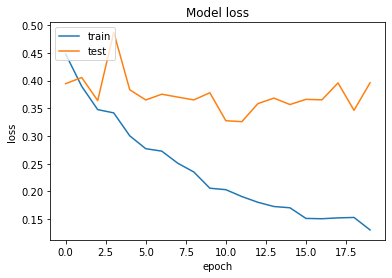

In [ ]:
plot_train_history(history)

# Confusion Matrix

In [ ]:
from keras.models import load_model

#filepath = "/content/bestmodel.hdf5"

# Load the model
#model = load_model(filepath, compile = True)

preds = model.predict_generator(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       480
           1       0.78      0.80      0.79       495
           2       0.95      0.84      0.89       575
           3       0.92      0.78      0.84       601
           4       0.88      0.85      0.87       530
           5       0.86      0.92      0.89       479
           6       0.65      0.89      0.75       373
           7       0.95      0.97      0.96       499
           8       0.95      0.91      0.93       534
           9       0.97      0.92      0.94       534

    accuracy                           0.88      5100
   macro avg       0.88      0.88      0.88      5100
weighted avg       0.89      0.88      0.88      5100



# Predict Data

In [ ]:
import os

classes=['Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight', 
         'Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite',
         'Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
root = '/content/Tomato Leaf Diseases/'

os.makedirs(root+'Small Testing Set')
try:
    for i in classes:
        os.makedirs(root+'Small Testing Set/'+i+'/')
except OSError:
    print('error')
    pass

In [ ]:
smalltesting_dir = "/content/Tomato Leaf Diseases/Small Testing Set"

smalltesting_datagen = ImageDataGenerator(rescale=1.0/255.)

# VALIDATION GENERATOR.
smalltesting_generator = smalltesting_datagen.flow_from_directory(smalltesting_dir,
                                                        target_size=(224,224),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 0 images belonging to 10 classes.


In [ ]:
import numpy as np

def predict_one(model):
    image_batch, classes_batch = next(smalltesting_generator)
    predicted_batch = model.predict(image_batch)
    #print(image_batch.shape[0])
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = classes[the_pred]
      max=0
      for i in range(0, 10): 
        if pred[i] > max: 
            max = pred[i]
      val_pred = max
      #print(val_pred)
      the_class = np.argmax(classes_batch[k])
      #print('---------image {} ----------' .format(k))
      #print('the_pred', the_pred)
      #print('the_class', the_class)
      value = classes[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)

# Predict 2

Saving 33028adc-9dc2-4ac3-a7b9-7094200264f6___GCREC_Bact.Sp 3162.JPG to 33028adc-9dc2-4ac3-a7b9-7094200264f6___GCREC_Bact.Sp 3162.JPG
Saving 33950b17-918e-4243-bfbd-be33874b62c4___GCREC_Bact.Sp 3303.JPG to 33950b17-918e-4243-bfbd-be33874b62c4___GCREC_Bact.Sp 3303.JPG
Saving 34385d7a-a724-4577-898b-dc9b9deb8ed9___GCREC_Bact.Sp 6098.JPG to 34385d7a-a724-4577-898b-dc9b9deb8ed9___GCREC_Bact.Sp 6098.JPG
Saving 35797a1e-c933-4ae3-817f-abc07775075d___GCREC_Bact.Sp 3204.JPG to 35797a1e-c933-4ae3-817f-abc07775075d___GCREC_Bact.Sp 3204.JPG
Saving 37592d17-06d6-492a-a469-3726396ad71b___GCREC_Bact.Sp 5560.JPG to 37592d17-06d6-492a-a469-3726396ad71b___GCREC_Bact.Sp 5560.JPG
Saving 39585b95-2167-4dac-9993-f75aac8d38bc___GCREC_Bact.Sp 3538.JPG to 39585b95-2167-4dac-9993-f75aac8d38bc___GCREC_Bact.Sp 3538.JPG
Saving 40688c11-791b-465a-9476-a5069e24a56f___GCREC_Bact.Sp 3064.JPG to 40688c11-791b-465a-9476-a5069e24a56f___GCREC_Bact.Sp 3064.JPG
Saving 40860ca0-2ec2-43be-817d-ef19ae1c10af___GCREC_Bact.Sp 60

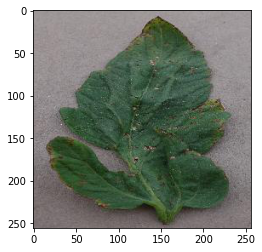

[2.1147139e-06 3.7300731e-05 9.8478496e-02 2.0372724e-04 3.5515488e-03
 3.6903471e-04 8.8798078e-03 5.4763284e-02 8.3160758e-01 2.1070773e-03]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Late blight: 9.85%
Tomato Leaf Mold: 0.02%
Tomato Septoria leaf spot: 0.36%
Tomato Spider mites Two-spotted mite: 0.04%
Tomato Target Spot: 0.89%
Tomato Yellow Leaf Curl Virus: 5.48%
Tomato healthy: 83.16%
Tomato mosaic virus: 0.21%


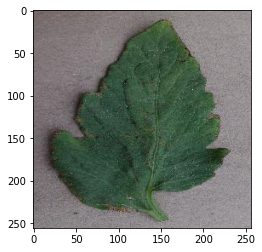

[5.8606838e-07 2.3163736e-03 4.4265483e-02 5.5977846e-03 1.1502504e-02
 1.8987297e-03 1.7103313e-01 2.4871415e-02 7.3182178e-01 6.6922251e-03]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.23%
Tomato Late blight: 4.43%
Tomato Leaf Mold: 0.56%
Tomato Septoria leaf spot: 1.15%
Tomato Spider mites Two-spotted mite: 0.19%
Tomato Target Spot: 17.10%
Tomato Yellow Leaf Curl Virus: 2.49%
Tomato healthy: 73.18%
Tomato mosaic virus: 0.67%


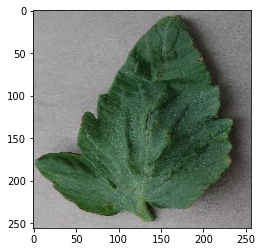

[9.2760010e-06 3.6833273e-05 3.8919852e-06 8.1797061e-06 1.6466122e-03
 2.3917623e-06 9.3506140e-01 1.2974188e-03 6.1928749e-02 5.2208270e-06]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Late blight: 0.00%
Tomato Leaf Mold: 0.00%
Tomato Septoria leaf spot: 0.16%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 93.51%
Tomato Yellow Leaf Curl Virus: 0.13%
Tomato healthy: 6.19%
Tomato mosaic virus: 0.00%


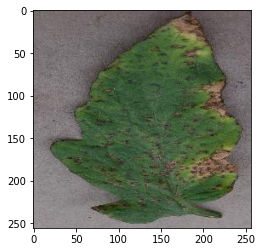

[2.5159863e-10 8.2696693e-07 3.0224153e-03 5.7233045e-08 2.3358855e-06
 3.4904257e-09 1.7081313e-04 9.1264764e-07 9.9679857e-01 4.0621362e-06]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Late blight: 0.30%
Tomato Leaf Mold: 0.00%
Tomato Septoria leaf spot: 0.00%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 0.02%
Tomato Yellow Leaf Curl Virus: 0.00%
Tomato healthy: 99.68%
Tomato mosaic virus: 0.00%


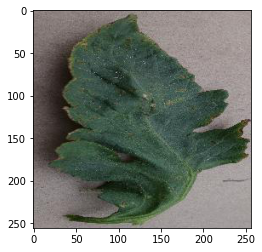

[4.0569961e-10 7.9616953e-08 4.3148915e-03 1.6639642e-06 4.3991103e-04
 1.5638153e-07 1.8413812e-03 5.1534036e-04 9.9261731e-01 2.6919600e-04]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Late blight: 0.43%
Tomato Leaf Mold: 0.00%
Tomato Septoria leaf spot: 0.04%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 0.18%
Tomato Yellow Leaf Curl Virus: 0.05%
Tomato healthy: 99.26%
Tomato mosaic virus: 0.03%


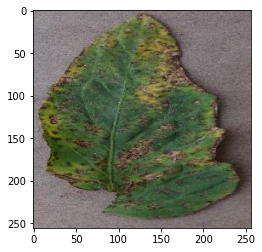

[3.03386287e-07 1.73469484e-02 1.50080845e-02 1.05136521e-02
 1.08968593e-01 2.24999255e-08 7.28180289e-01 2.00850583e-04
 1.19471967e-01 3.09269002e-04]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 1.73%
Tomato Late blight: 1.50%
Tomato Leaf Mold: 1.05%
Tomato Septoria leaf spot: 10.90%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 72.82%
Tomato Yellow Leaf Curl Virus: 0.02%
Tomato healthy: 11.95%
Tomato mosaic virus: 0.03%


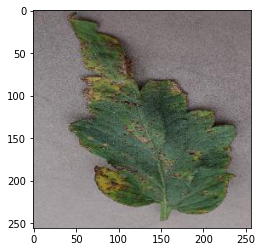

[5.1262392e-05 7.3839241e-05 1.8300697e-01 1.1883377e-05 1.2169170e-04
 2.5346666e-10 7.9059698e-02 4.8610424e-08 7.3765916e-01 1.5443147e-05]
Tomato Bacterial spot: 0.01%
Tomato Early blight: 0.01%
Tomato Late blight: 18.30%
Tomato Leaf Mold: 0.00%
Tomato Septoria leaf spot: 0.01%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 7.91%
Tomato Yellow Leaf Curl Virus: 0.00%
Tomato healthy: 73.77%
Tomato mosaic virus: 0.00%


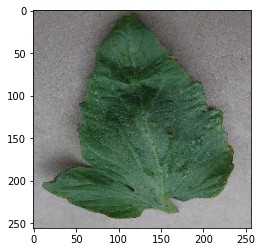

[7.6834095e-07 3.9328850e-05 5.1921462e-03 3.2601546e-04 8.8428293e-04
 1.5960991e-07 2.3324586e-02 3.4723213e-05 9.6986258e-01 3.3544909e-04]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Late blight: 0.52%
Tomato Leaf Mold: 0.03%
Tomato Septoria leaf spot: 0.09%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 2.33%
Tomato Yellow Leaf Curl Virus: 0.00%
Tomato healthy: 96.99%
Tomato mosaic virus: 0.03%


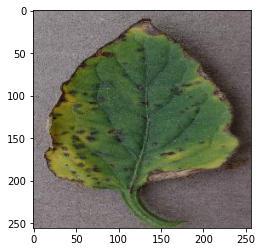

[3.0629669e-06 1.7459493e-05 2.1642892e-02 2.6489286e-05 2.4300518e-05
 4.1624344e-06 6.2124759e-02 7.9139807e-07 9.1615498e-01 1.0950162e-06]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Late blight: 2.16%
Tomato Leaf Mold: 0.00%
Tomato Septoria leaf spot: 0.00%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 6.21%
Tomato Yellow Leaf Curl Virus: 0.00%
Tomato healthy: 91.62%
Tomato mosaic virus: 0.00%


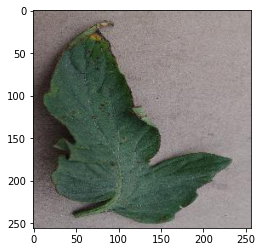

[5.2684626e-08 9.4119787e-05 1.6551755e-03 1.4179875e-04 2.4459762e-03
 8.3471673e-07 1.3618862e-02 5.4521718e-07 9.7942024e-01 2.6223832e-03]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.01%
Tomato Late blight: 0.17%
Tomato Leaf Mold: 0.01%
Tomato Septoria leaf spot: 0.24%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 1.36%
Tomato Yellow Leaf Curl Virus: 0.00%
Tomato healthy: 97.94%
Tomato mosaic virus: 0.26%


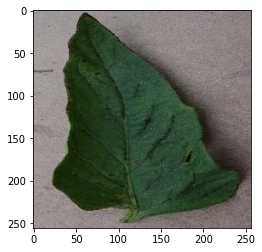

[1.0686073e-06 1.4854499e-05 1.0293662e-03 6.9320516e-04 7.3184913e-01
 5.6002949e-07 5.9565450e-03 2.5901988e-03 2.5230405e-01 5.5609997e-03]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.00%
Tomato Late blight: 0.10%
Tomato Leaf Mold: 0.07%
Tomato Septoria leaf spot: 73.18%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 0.60%
Tomato Yellow Leaf Curl Virus: 0.26%
Tomato healthy: 25.23%
Tomato mosaic virus: 0.56%


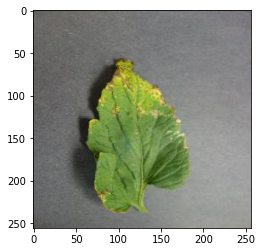

[1.3070406e-08 8.6383283e-04 6.7565800e-03 6.0357093e-03 6.1071012e-03
 2.1630953e-08 3.3250563e-02 3.0608305e-06 9.4561583e-01 1.3672587e-03]
Tomato Bacterial spot: 0.00%
Tomato Early blight: 0.09%
Tomato Late blight: 0.68%
Tomato Leaf Mold: 0.60%
Tomato Septoria leaf spot: 0.61%
Tomato Spider mites Two-spotted mite: 0.00%
Tomato Target Spot: 3.33%
Tomato Yellow Leaf Curl Virus: 0.00%
Tomato healthy: 94.56%
Tomato mosaic virus: 0.14%


In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

labels = list(train_generator.class_indices.keys())

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  print(proba)
  for i in range(len(labels)):
    print("{}: {:.2f}%".format(labels[i], proba[i]* 100))